## Предобработка данных

Импортируем данные

In [33]:
# Импортируем данные
import pandas as pd
from import_dat import column_names, unclaimed_columns

df = pd.read_csv('4fgl_full.dat', 
                sep='\s+', 
                header=None,
                index_col=0,
                names=column_names,
                )

Проверяем, сколько различных типов объектов

In [34]:
from import_dat import *
for i in df['source_type'].unique():
    print(i, ' — ', source_classes[i])

bcu  —  Blazar candidate of uncertain type
unk  —  Unknown
bll  —  BL Lac type of blazar
fsrq  —  FSRQ type of blazar
MSP  —  Millisecond pulsar
lmb  —  Low-mass binary
FSRQ  —  FSRQ type of blazar
GAL  —  Normal galaxy (or part)
rdg  —  Radio galaxy
sfr  —  Star-forming region
glc  —  Globular cluster
snr  —  Supernova remnant
PSR  —  Pulsar, identified by pulsations
pwn  —  Pulsar wind nebula
msp  —  Millisecond pulsar
HMB  —  High-mass binary
LMB  —  Low-mass binary
sey  —  Seyfert galaxy
PWN  —  Pulsar wind nebula
spp  —  Supernova remnant / Pulsar wind nebula
SNR  —  Supernova remnant
SPP  —  Supernova remnant / Pulsar wind nebula
psr  —  Pulsar, no pulsations seen in LAT yet
gal  —  Normal galaxy (or part)
BIN  —  Binary
NOV  —  Nova
SFR  —  Star-forming region
bin  —  Binary
sbg  —  Starburst galaxy
BLL  —  BL Lac type of blazar
nlsy1  —  Narrow-line Seyfert 1
RDG  —  Radio galaxy
AGN  —  Non-blazar active galaxy
agn  —  Non-blazar active galaxy
hmb  —  High-mass binary
GC  —  G

Отсеиваем только блазары и квазары, а также `unknown`. Остальные типы помечаем как `other`

In [35]:
from utility import normalize_source_type
df_processed = normalize_source_type(df)
df_processed['source_type'].value_counts()

blazar     3934
unknown    2577
other       543
pulsar      141
Name: source_type, dtype: int64

Разделяем выборку на известные и неизвестные типы

In [36]:
df_known = df_processed[df_processed['source_type'] != 'unknown'].copy()
df_unknown = df_processed[df_processed['source_type'] == 'unknown'].copy()

Вместо исходных классов делаем dummy variables для df_known

In [37]:
df_dummies = pd.get_dummies(df_known, columns=['source_type'], prefix='source')
df_dummies.head()

,ra,dec,flux_1_100_gev,flux_1_100_gev_error,detection_significance,semi_major_axis_68,semi_minor_axis_68,position_angle_68,semi_major_axis_95,semi_minor_axis_95,...,npred,variability_index,frac_variability,frac_variability_error,significance_peak,flux_peak,flux_peak_error,source_blazar,source_other,source_pulsar
name,,,,,,,,,,,,,,,,,,,,,
J0908.5-8751,137.150,-86.1339,1.166700e-10,2.546200e-11,6.2932,0.0929,0.0782,-14.12,0.1506,0.1268,...,830.55,28.699499,0.4840,0.1895,6.247304,2.386100e-08,4.128800e-09,1,0,0
J1354.1-8750,208.545,-86.1603,1.298300e-10,2.774600e-11,4.5903,0.0626,0.0607,-71.19,0.1015,0.0984,...,473.70,8.378150,0.0000,10.0000,0.000000,0.000000e+00,0.000000e+00,1,0,0
J2109.8-8618,317.462,-85.6922,2.953600e-10,3.429700e-11,16.7126,0.0236,0.0175,79.28,0.0382,0.0284,...,411.17,19.224632,0.2585,0.1825,0.000000,0.000000e+00,0.000000e+00,1,0,0
J1027.0-8542,156.765,-84.2836,1.082000e-09,5.312100e-11,39.3804,0.0113,0.0107,-51.78,0.0184,0.0173,...,1242.32,8.896601,0.0000,10.0000,0.000000,0.000000e+00,0.000000e+00,1,0,0
J0931.2-8533,142.818,-84.4375,3.765200e-10,3.764600e-11,13.3109,0.0361,0.0318,6.40,0.0586,0.0516,...,1232.80,77.880920,0.7432,0.1713,10.234067,3.113400e-08,3.735300e-09,1,0,0


Разделяем выборку на тренировочную и тестовую

In [38]:
from sklearn.model_selection import train_test_split

# Разбиваем данные на train и test выборки
data_train, data_test = train_test_split(df_dummies, test_size=0.2)

In [39]:
data_train.shape

(3694, 48)

Аугментируем тренировочные данные с помощью гауссового шума на основе ошибок 

In [40]:
from utility import augmentation

data_train_aug = augmentation(data_train, error_columns=unclaimed_columns, times = 0)

In [41]:
data_train_aug.shape

(3694, 48)

Делим переменные на параметры и target

In [42]:
# Выделяем target-переменные
target_columns = ['source_blazar','source_other','source_pulsar']

# Выделяем target-переменные
X_train = data_train_aug.drop(target_columns, axis=1)
y_train = data_train_aug[target_columns]

# Аналогично — выделяем в тестовой выборке
X_test = data_test.drop(target_columns, axis=1)
y_test = data_test[target_columns]

In [43]:
print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Размерность y_test: {y_test.shape}")

Размерность X_train: (3694, 45)
Размерность y_train: (3694, 3)
Размерность X_test: (924, 45)
Размерность y_test: (924, 3)


Избавляемся от самих столбцов с ошибками

In [44]:
X_train = X_train.drop(unclaimed_columns, axis=1).reset_index(drop=True)
X_test = X_test.drop(unclaimed_columns, axis=1).reset_index(drop=True)
df_unknown = df_unknown.drop(unclaimed_columns, axis=1).reset_index(drop=True)

Нормируем данные

In [45]:
from sklearn.preprocessing import RobustScaler
from utility import normalize_df

# Инициализируем скейлер и 'обучаем' его на наших данных
scaler = RobustScaler()
scaled_data = scaler.fit(X_train.select_dtypes(include='number'))

# Нормируем данные с одним и тем же скейлером
X_train = normalize_df(X_train, scaler)
X_test = normalize_df(X_test, scaler)
df_unknown = normalize_df(df_unknown, scaler)

## Обучение нейросети

### Построение архитектуры

Создаём экземпляр нейронной сети

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras import regularizers

# Построение модели нейронной сети
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='leaky_relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

# Компиляция модели
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

#### Обучение модели

Задаём веса отдельным классам для компенсации их диспропорции

In [47]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                     classes = np.unique(df_known['source_type']), 
                                     y = df_known['source_type']
                                     )

class_weight_dict = dict(enumerate(class_weights))

Обучаем модель с полученными весами

Epoch 1/50
37/37 [==============================] - 1s 8ms/step - loss: 37.6445 - accuracy: 0.2179 - val_loss: 2.1484 - val_accuracy: 0.2825
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 10.0423 - accuracy: 0.3584 - val_loss: 1.9253 - val_accuracy: 0.4578
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 30.1873 - accuracy: 0.4491 - val_loss: 1.7507 - val_accuracy: 0.5574
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 2.8801 - accuracy: 0.5135 - val_loss: 1.6843 - val_accuracy: 0.6093
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 5.3271 - accuracy: 0.5360 - val_loss: 1.5153 - val_accuracy: 0.6472
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 9.7185 - accuracy: 0.5723 - val_loss: 1.4303 - val_accuracy: 0.6548
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 16.8774 - accuracy: 0.5755 - val_loss: 1.2047 - val_accuracy: 0.6742
Epoch 8/50
37/37

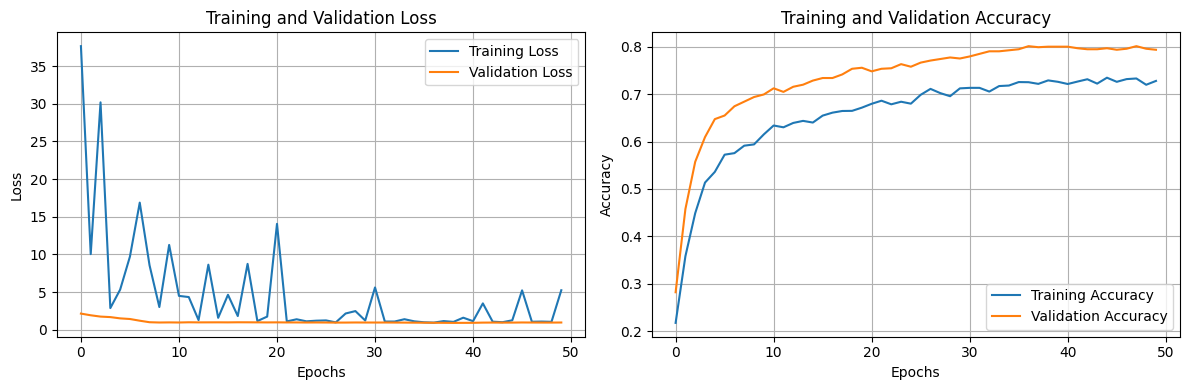

In [48]:
from utility import visualize_training_history

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=100, 
                    validation_data=(X_test, y_test), 
                    class_weight=class_weight_dict
                    )

visualize_training_history(history)

29/29 [==============================] - 0s 2ms/step - loss: 0.5111 - accuracy: 0.8095


ValueError: X must be a NumPy array. Found <class 'pandas.core.frame.DataFrame'>

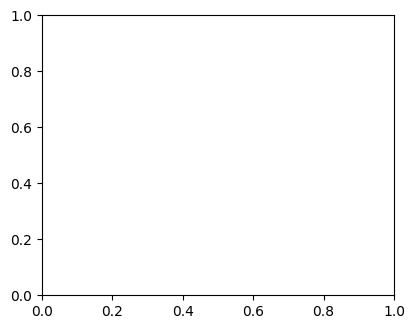

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

labels = ['Logistic Regression']
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([model], labels, itertools.product([0, 1], repeat=2)):
    clf.fit(X_test, y_test)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_test, y=y_test, clf=clf, legend=2)
    plt.title(lab)

plt.show()



Классификация неизвестных источников

In [21]:
X_validation = df_unknown.drop(['source_type'], axis=1)
predictions = model.predict(X_validation)

81/81 [==============================] - 0s 989us/step


In [22]:
from utility import combine_predictions

df_predicted = df_unknown.copy()

df_predicted[['blazar', 'other', 'pulsar']] = predictions
df_predicted['predicted_class'] = combine_predictions(predictions, threshold=0, ratio_threshold=1)

# Выводим на экран результаты
df_predicted#[df_predicted['predicted_class'] == 2]

,source_type,ra,dec,flux_1_100_gev,detection_significance,semi_major_axis_68,semi_minor_axis_68,position_angle_68,semi_major_axis_95,semi_minor_axis_95,...,plec_epeak,npred,variability_index,frac_variability,significance_peak,flux_peak,blazar,other,pulsar,predicted_class
0,unknown,-0.564440,-1.390173,0.309145,0.539444,-0.174515,-0.239700,0.698837,-0.174359,-0.237875,...,0.301743,0.317157,0.103903,-0.198456,0.0,0.0,0.636561,0.306846,0.056593,0
1,unknown,0.700205,-1.396580,-0.398474,-0.343614,-0.044321,0.018727,-0.534304,-0.044444,0.020785,...,3.914108,-0.587280,-0.064839,-0.562810,0.0,0.0,0.392212,0.555993,0.051795,1
2,unknown,0.140189,-1.400915,-0.366866,-0.551423,0.529086,0.715356,-0.798922,0.528205,0.715935,...,-0.069899,-0.199019,-0.099975,-0.562810,0.0,0.0,0.622076,0.265321,0.112603,0
3,unknown,-0.695332,-1.382711,-0.080511,-0.169921,1.119114,0.513109,-0.222738,1.117949,0.515012,...,0.213671,-0.234671,-0.288200,-0.562810,0.0,0.0,0.481076,0.433841,0.085083,0
4,unknown,0.995199,-1.345870,-0.254120,-0.281323,-0.177285,-0.153558,0.408717,-0.177778,-0.152425,...,0.543269,-0.346051,-0.199309,-0.562810,0.0,0.0,0.565017,0.378055,0.056929,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,unknown,-0.883524,1.285748,-0.280350,-0.317175,0.573407,0.198502,-0.541133,0.574359,0.198614,...,1.001459,-0.341679,0.034143,-0.171030,0.0,0.0,0.763405,0.205541,0.031054,0
2573,unknown,-0.015391,1.305656,-0.284186,-0.284733,1.044321,0.850187,-0.047535,1.044444,0.849885,...,-0.069899,0.000702,-0.198211,-0.328387,0.0,0.0,0.642613,0.281329,0.076058,0
2574,unknown,0.959536,1.310613,-0.306333,-0.445554,2.290859,2.041199,0.254321,2.290598,2.041570,...,0.039793,-0.152087,-0.337211,-0.562810,0.0,0.0,0.219560,0.641635,0.138805,1
2575,unknown,-1.029866,1.331670,-0.365028,-0.506460,1.268698,1.546816,-0.573784,1.268376,1.549654,...,0.305183,-0.337563,-0.209326,-0.562810,0.0,0.0,0.669766,0.279441,0.050793,0
